# 한글설정

In [7]:
!apt-get install fonts-nanum* > /dev/null 2>&1
!fc-cache -fv > /dev/null 2>&1

In [8]:
import os
import matplotlib as mpl

file_dir = os.path.split(mpl.__file__)[0]
font_dir = os.path.join(file_dir, 'mpl-data/fonts/ttf')
!cp /usr/share/fonts/truetype/nanum/Nanum* {font_dir}
!rm -rf ~/.cache/matplotlib/*

> Runtime Restart

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumGothicCoding')

# 데이터 가져오기

In [4]:
import os
import gdown

id = "10Hpa4YM0KX_Ig0W9w7DbTdq62nF2UThA"
output = "./open.zip"

if not os.path.isdir('./datasets'):
  gdown.download(id=id, output=output)
  gdown.extractall(path=output, to='./datasets')

Downloading...
From: https://drive.google.com/uc?id=10Hpa4YM0KX_Ig0W9w7DbTdq62nF2UThA
To: /content/open.zip
100% 10.0M/10.0M [00:01<00:00, 8.83MB/s]


# 데이터프레임 만들기

In [22]:
import os
import glob
import pandas as pd
from collections import defaultdict

raw_data = defaultdict(pd.DataFrame)

for fname in glob.glob('./**/*.csv', recursive=True):
    df_name = os.path.splitext(os.path.basename(fname))[0]
    raw_data[df_name] = pd.read_csv(fname)

* 정상(Normal)과 불량(Error) 데이터 분리

In [23]:
train = raw_data['train'].copy()
train['Status'] = 'Normal'
for idx, val in raw_data['y_feature_spec_info'].iterrows():
    train.loc[(train[val['Feature']] < val['최소']) | (train[val['Feature']] > val['최대']), ['Status']] = 'Error'

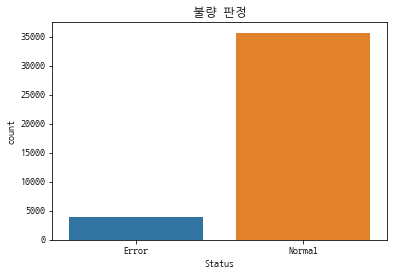

In [24]:
import seaborn as sns

sns.countplot(x='Status', data=train)
plt.title('불량 판정')
plt.show()

# 평가함수

In [59]:
import numpy as np
from sklearn import metrics

# 데이콘에서 제공한 평가함수
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    # gt = gt.to_numpy()
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:14])
    return score

In [56]:
from sklearn.preprocessing import QuantileTransformer

def apply_scaler(input, except_colnums=[]):
  data = input.copy()

  columns = list(data.filter(regex='X').columns)
  for cname in except_colnums:
    columns.remove(cname)

  qt = QuantileTransformer(output_distribution="normal")
  for cname in columns:
    data[cname] = qt.fit_transform(data[cname].values.reshape(-1, 1))

  output = data.copy()
  return output

In [27]:
def get_outlier(df=None, column=None, weight=1.5, status='Error'):
    fraud = df[df['Status'] == status][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index

    return outlier_index

def remove_outlier(df, columns, status, weight, max_limit=40000):
    outlier_list = []

    for colname in columns: 
        outlier = get_outlier(df, colname, weight=weight, status=status)
        if len(outlier) > max_limit:
            continue
        outlier_list.extend(outlier)

    result = df.drop(outlier_list, axis=0).copy()

    return result

# 학습하기

In [82]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

scaler_list = [
    ('Unscaled', None),
    ('Standard', StandardScaler()),
    ('Min-Max', MinMaxScaler()),
    ('Min-Abs', MaxAbsScaler()),
    ('Robust', RobustScaler(quantile_range=(25, 75))),
    ('uniform pdf', QuantileTransformer(output_distribution="uniform")),
    ('gaussian pdf', QuantileTransformer(output_distribution="normal")),
    ('L2 normalizing', Normalizer())
]

In [83]:
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold



def run_train(scaler=None):

  kf = KFold(shuffle=True, random_state=13)
  loss = []
  
  # 데이터 나누기
  X, y = train.filter(regex='X').values, train.filter(regex='Y').values
  for train_index, test_index in kf.split(X):
    since = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 파이프라인 작성
    pipe = make_pipeline( 
      scaler[1], 
      RandomForestRegressor(criterion="squared_error", random_state=13, n_jobs=-1, n_estimators=200)
    )

    # 학습하기
    pipe.fit(X_train, y_train)

    # 검증하기
    y_pred = pipe.predict(X_test)

    # 평가 및 기록
    elapsed = time.time() - since
    result = lg_nrmse(y_test, y_pred)
    print("Loss: {:.4f}, Elapsed Time: {:.2f}".format(result, elapsed))
    loss.append(result)
  print("{}, Best: {:.4f}, Avg:{:.4f}".format(scaler[0], min(loss), np.mean(loss)))

  return pipe[1], result

In [86]:
best_loss = 15

for scaler in scaler_list:
    model, result = run_train(scaler=scaler)
    if result < best_loss:
        best_loss = result
        best_model = model
        


# 결과파일 작성

In [ ]:
def make_summit(model):
  test = raw_data['test'].drop(columns=['ID']).copy()

  test = apply_scaler(test)

  preds = model.predict(test)
  print('Done.')

  submit = raw_data['sample_submission'].copy()
  for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,idx-1]
  print('Done.')

  submit.to_csv('/content/submit.csv', index=False)
  print('Done.')

make_summit(best_model)

Done.
Done.
Done.
